In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

BASEDIR = "/data1/shahs3/users/sunge/cnv_simulator"
HMMCOPY_DIR = f"{BASEDIR}/hmmcopy"
BAMDIR = "/data1/shahs3/users/sunge/cnv_simulator/synthetic_bams_2"
sample_name = "PM_0510_EGFR"

select_chroms = ["7"]


## Helper Functions

In [27]:
def long_to_cell_bin_matrix(df, select_chr, value_col="state"):
    """
    Converts a long-format DataFrame with cell/bin rows into a wide matrix
    with cells as rows and bins as columns.
    
    Parameters:
    - df: pandas DataFrame with columns including 'start', 'end', 'chr', 'cell_id', and value_col
    - value_col: the column to pivot into the matrix values (default = 'reads')
    
    Returns:
    - A DataFrame with cell_id as the index and bins as columns
    """
    # Create a unique bin label for columns
    df = df[df['chr'].isin(select_chr)].copy()
    df['bin_id'] = df['chr'].astype(str) + ":" + df['start'].astype(str) + "-" + df['end'].astype(str)

    # Pivot to matrix format
    matrix = df.pivot(index='cell_id', columns='bin_id', values=value_col)

    # Optional: sort columns by chromosome and position
    matrix.columns.name = None
    matrix = matrix.sort_index(axis=1, key=lambda col: [
        (int(x.split(":")[0]), int(x.split(":")[1].split("-")[0])) for x in col
    ])

    return matrix


state_colors = {
    "0": "#2C78B2",  # Dark blue
    "1": "#94C4DB",  # Light blue
    "2": "#C5C5C5",  # Gray
    "3": "#FCC484",  # Light orange
    "4": "#FA8154",  # Orange
    "5": "#DD4031",  # Red-orange
    "6": "#A9000D",  # Dark red
    "7": "#8C033A",  # Burgundy
    "8": "#6A1B9A",  # Medium purple
    "9": "#4A148C",  # Dark purple
    "10": "#38006B",  # Very dark purple
    "11": "#2E0057",  # Deep purple
    "12": "#240043",  # Almost black purple
    "13": "#1A002F",  # Darkest purple
    "14": "#12001C",  # Near-black purple
}

def plot_state_heatmap(matrix, state_colors, cell_to_clone_df=None, row_cluster = False,
                       title="HMM Copy States",
                       save_path = None):
    """
    Plots a heatmap of HMM copy states with optional row coloring by clone.

    Parameters:
    - matrix: DataFrame with cells as rows, bins as columns.
    - state_colors: dict mapping state (as str or int) to hex color codes.
    - cell_to_clone_df: optional DataFrame with 'cell_barcode' and 'clone' columns.
    - title: Title of the heatmap.
    """
    # Ensure matrix is numeric integers
    matrix = matrix.astype(int)

    row_colors = None
    if cell_to_clone_df is not None:
        # Map clone labels to matrix index
        clone_map = cell_to_clone_df.set_index("cell_barcode")["clone"]
        matrix["clone"] = matrix.index.map(clone_map)

        # Sort by clone
        matrix = matrix.sort_values("clone")
        clone_labels = matrix["clone"]
        matrix = matrix.drop(columns="clone")

        # Map clone labels to colors
        unique_clones = sorted(clone_labels.dropna().unique())
        palette = sns.color_palette("tab10", n_colors=len(unique_clones))
        clone_color_map = {clone: palette[i] for i, clone in enumerate(unique_clones)}
        row_colors = clone_labels.map(clone_color_map)

    # Chromsome boundaries
    bin_chroms = matrix.columns.str.extract(r'^([^:]+):')[0]
    chr_start_pos = [0]
    chr_labels = [bin_chroms.iloc[0]]
    for i in range(1, len(bin_chroms)):
        if bin_chroms[i] != bin_chroms[i - 1]:
            chr_start_pos.append(i)
            chr_labels.append(bin_chroms[i])

    # Create colormap + normalization
    sorted_states = sorted(int(k) for k in state_colors.keys())
    cmap = mcolors.ListedColormap([state_colors[str(k)] for k in sorted_states])
    boundaries = [s - 0.5 for s in sorted_states] + [sorted_states[-1] + 0.5]
    norm = mcolors.BoundaryNorm(boundaries, cmap.N)

    # Plot
    sns.set(font_scale=0.8)
    cluster_plt = sns.clustermap(
        matrix,
        cmap=cmap,
        norm=norm,
        row_colors=row_colors,
        cbar_kws={"label": "HMM State", "ticks": sorted_states},
        row_cluster=row_cluster,
        col_cluster=False,
        xticklabels=False,
        yticklabels=False,
        # figsize=(12, 8),
        cbar_pos=(1.03, 0.3, 0.03, 0.5),
        dendrogram_ratio=(0.01, 0.01),
    )

    cluster_plt.ax_heatmap.set_ylabel("Cells")
    cluster_plt.fig.suptitle(title, y=1.02)

    ax = cluster_plt.ax_heatmap
    for pos in chr_start_pos:
        ax.axvline(x=pos, color='white', linewidth=2, linestyle='-')
    midpoints = [(chr_start_pos[i] + chr_start_pos[i + 1]) / 2 for i in range(len(chr_start_pos) - 1)]
    midpoints.append((chr_start_pos[-1] + len(matrix.columns)) / 2)
    ax.set_xticks(midpoints)
    ax.set_xticklabels(chr_labels, ha='right')

    if save_path != None:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Saved heatmap to {save_path}")

    plt.show()



## Plots

In [28]:
hmmcopy_df = pd.read_csv(f"{HMMCOPY_DIR}/output/aliquot_hmmcopy/{sample_name}_hmmcopy_reads.csv.gz")
# hmmcopy_df = pd.read_csv(f"{HMMCOPY_DIR}/SPECTRUM-OV-045_S1_CD45N_INFRACOLIC_OMENTUM_A108867A_L2_hmmcopy_reads.csv.gz")

n_unique_cells = hmmcopy_df['cell_id'].nunique()
print(f"Number of unique cells: {n_unique_cells}")
print(hmmcopy_df.shape)
print(hmmcopy_df.columns)
hmmcopy_df.head()

Number of unique cells: 301
(1868006, 16)
Index(['start', 'end', 'chr', 'reads', 'gc', 'map', 'cor_gc', 'copy', 'valid',
       'ideal', 'modal_curve', 'modal_quantile', 'cor_map', 'multiplier',
       'state', 'cell_id'],
      dtype='object')


,start,end,chr,reads,gc,map,cor_gc,copy,valid,ideal,modal_curve,modal_quantile,cor_map,multiplier,state,cell_id
0,1,500000,1,0,0.423964,0.348523,NaN,NaN,False,False,NaN,NaN,NaN,1,2,A108832A-R26-C51
1,500001,1000000,1,0,0.501412,0.770391,NaN,NaN,False,False,NaN,NaN,NaN,1,2,A108832A-R26-C51
2,1000001,1500000,1,0,0.598332,0.982072,NaN,NaN,False,False,NaN,NaN,NaN,1,2,A108832A-R26-C51
3,1500001,2000000,1,0,0.539498,0.963004,NaN,NaN,False,False,NaN,NaN,NaN,1,2,A108832A-R26-C51
4,2000001,2500000,1,0,0.594508,0.997066,NaN,NaN,False,False,NaN,NaN,NaN,1,2,A108832A-R26-C51


In [30]:
cell_profile_df = pd.read_csv(f"{BAMDIR}/{sample_name}/{sample_name}_cell_profile.tsv", sep = "\t")
cell_profile_df = cell_profile_df[(cell_profile_df["chr"] == 0) & (cell_profile_df["clone"] != -1)]

rows = []
for _, row in cell_profile_df.iterrows():
    clone_id = row["clone"]
    barcodes = row["cell_barcode"].split(",")
    for bc in barcodes:
        rows.append({"cell_barcode": bc, "clone": clone_id})
cell_clone_df = pd.DataFrame(rows)

print(cell_clone_df.shape)
cell_clone_df.head()

(301, 2)


,cell_barcode,clone
0,128744A-R13-C27,0
1,A96123A-R26-C64,0
2,128663A-R49-C21,0
3,128724A-R65-C25,0
4,A96123A-R26-C08,0


In [31]:
state_matrix = long_to_cell_bin_matrix(hmmcopy_df, select_chroms, value_col="state")

print(state_matrix.shape)
state_matrix

(301, 319)


,7:1-500000,7:500001-1000000,7:1000001-1500000,7:1500001-2000000,7:2000001-2500000,7:2500001-3000000,7:3000001-3500000,7:3500001-4000000,7:4000001-4500000,7:4500001-5000000,...,7:154500001-155000000,7:155000001-155500000,7:155500001-156000000,7:156000001-156500000,7:156500001-157000000,7:157000001-157500000,7:157500001-158000000,7:158000001-158500000,7:158500001-159000000,7:159000001-159500000
cell_id,,,,,,,,,,,,,,,,,,,,,
110642-R22-C59,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
110716-R19-C29,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
110720-R14-C58,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
110720-R16-C58,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
110720-R16-C59,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A98245B-R64-C68,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
A98245B-R66-C34,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
A98245B-R67-C51,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


Saved heatmap to /data1/shahs3/users/sunge/cnv_simulator/synthetic_bams_2/PM_0510_EGFR/figs/PM_0510_EGFR_hmmcopy_heatmap.png


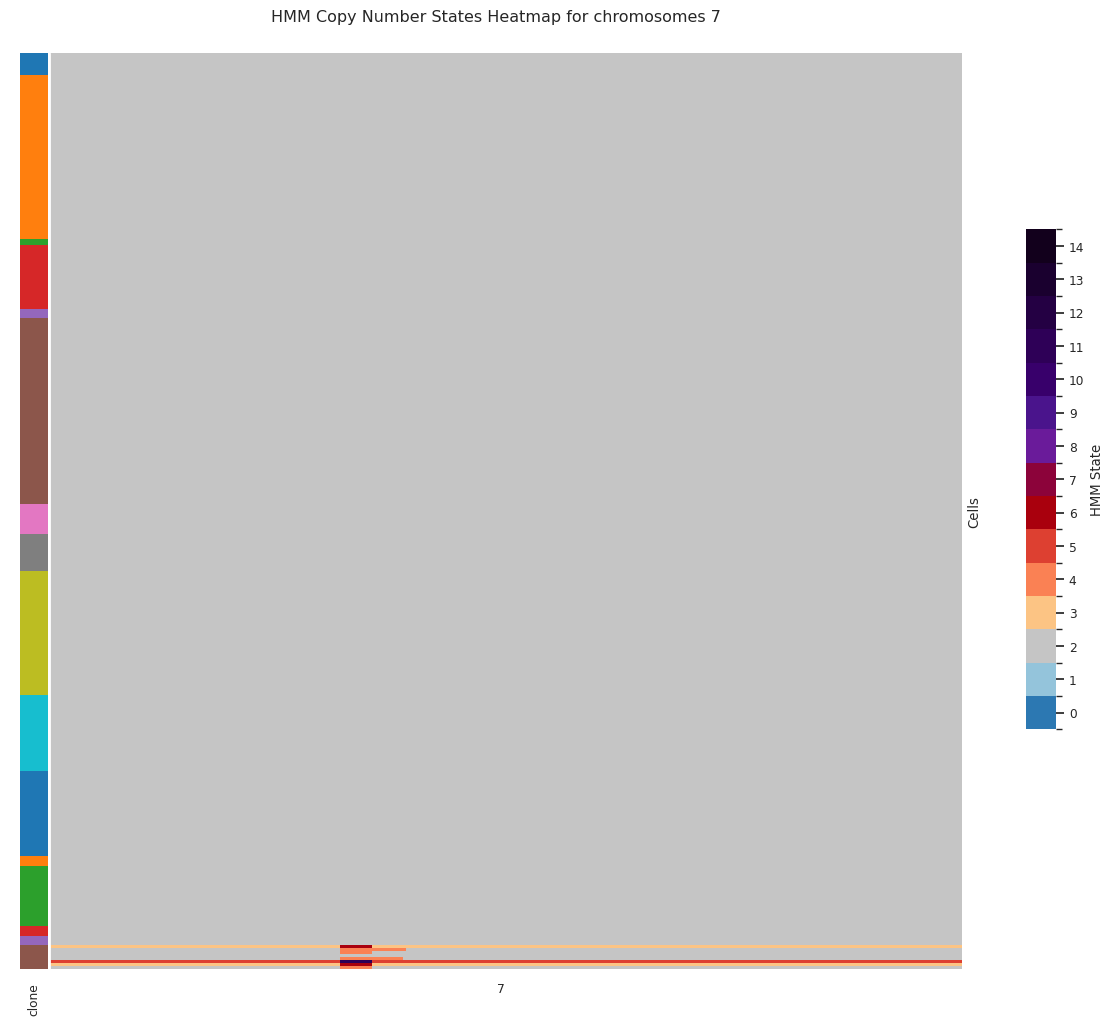

In [32]:
hmmcopy_save_path = f"{BAMDIR}/{sample_name}/figs/{sample_name}_hmmcopy_heatmap.png"

plot_state_heatmap(state_matrix, state_colors, cell_to_clone_df=cell_clone_df,
                   row_cluster = False, 
                   title=f"HMM Copy Number States Heatmap for chromosomes {','.join(select_chroms)}",
                   save_path=hmmcopy_save_path)